Example is based on *Joho, Dominik, Maren Bennewitz, and Sven Behnke. "Pitch estimation using models of voiced speech on three levels." 2007 IEEE International Conference on Acoustics, Speech and Signal Processing-ICASSP'07. Vol. 4. IEEE, 2007.*

https://www.ais.uni-bonn.de/nimbro/papers/ICASSP07_Joho.pdf

In [1]:
%matplotlib inline

import librosa
from librosa import display
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from torch import nn
import torch.nn.functional as F
from torchaudio import load
from torchaudio.functional import griffinlim
from scipy.signal import fftconvolve, windows
from tqdm import tqdm

from torchnmf.nmf import NMF, NMFD
from torchnmf.trainer import BetaMu
from torchnmf.metrics import beta_div

# this for playing audio
import IPython.display as ipd

# Speech Signal

torch.Size([88200]) 22050


/home/ycy/miniconda3/envs/torch170/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/ycy/miniconda3/envs/torch170/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/ycy/miniconda3/envs/torch170/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


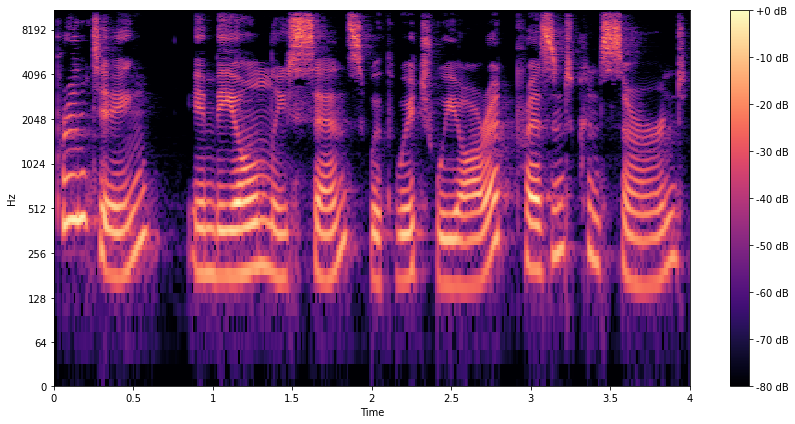

torch.Size([88200]) torch.Size([345, 513]) 22050


In [2]:
y, sr = load(os.path.expanduser('~/data-disk/Datasets/LJSpeech-1.1/wavs/LJ001-0001.wav'), num_frames=88200)
y = y.mean(0)
print(y.shape, sr)

nfft = 1024
hop_length = 256
window = torch.hann_window(nfft)

Sraw = torch.stft(y, nfft, window=window, hop_length=hop_length, return_complex=True)
S = Sraw.abs().t()

fig = plt.figure(figsize=(12, 6))
display.specshow(librosa.amplitude_to_db(S.numpy().T, ref=np.max), y_axis='log', x_axis='time', sr=sr, hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

print(y.shape, S.shape, sr)

In [3]:
ipd.Audio(y.numpy(), rate=sr)

## Vanilla NMF

In [4]:
model = NMF(S.shape, rank=50)
model.fit(S, verbose=True)

 70%|███████   | 140/200 [00:00<00:00, 287.08it/s, loss=103]


140

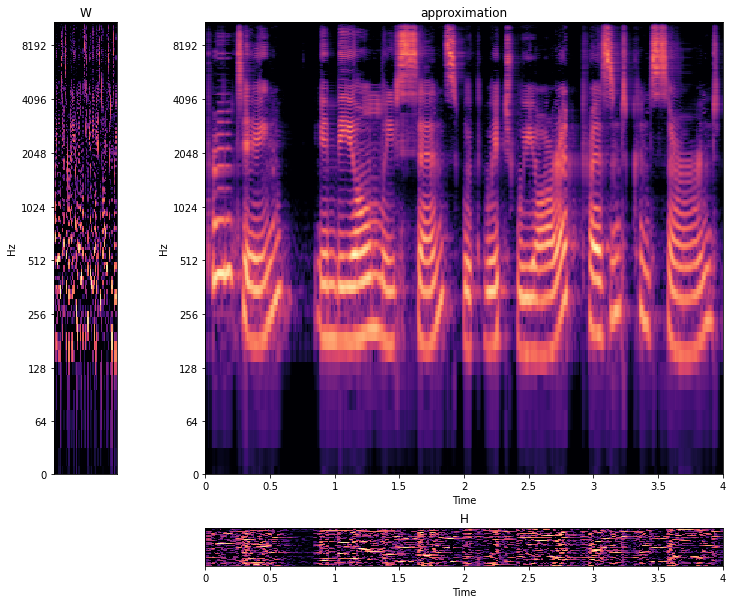

In [5]:
approx = model().detach().cpu().numpy().T
W = model.W.detach().cpu().numpy()
H = model.H.detach().cpu().numpy().T


fig = plt.figure(figsize=(12, 10))
ax1 = plt.subplot2grid((12, 9), (0, 2), colspan=7, rowspan=10)
ax2 = plt.subplot2grid((12, 9), (0, 0), rowspan=10)
ax3 = plt.subplot2grid((12, 9), (11, 2), colspan=7)

img1 = display.specshow(librosa.amplitude_to_db(approx, ref=np.max), y_axis='log', x_axis='time', 
                        sr=sr, hop_length=hop_length, ax=ax1)
ax1.set(title="approximation")
display.specshow(librosa.amplitude_to_db(W, ref=np.max), y_axis='log',
                 sr=sr, ax=ax2)
ax2.set(title="W")
display.specshow(librosa.amplitude_to_db(H, ref=np.max), x_axis='time', 
                 sr=sr, hop_length=hop_length, ax=ax3)
ax3.set(title="H")
# fig.colorbar(img1, ax=ax)
plt.show()

## Define Harmonic Templates and Vocal Tract Filter

In [6]:
def get_harmonics(fmin=120, fmax=500):
    Ust = 10
    step_size = np.log(2) / 12 / Ust
    freqs = np.exp(np.arange(np.log(fmin), np.log(fmax), step_size))

    tmp = []
    for f in freqs:
        h = np.arange(int(0.5 * sr / f)) + 1
        #h = h[:40]
        ch = f * 27 / 4 * (np.exp(-1j * np.pi * h) + 
                           2 * (1 + 2 * np.exp(-1j * np.pi * h)) / (1j * np.pi * h) - 
                           6 * (1 - np.exp(-1j * np.pi * h)) / (1j * np.pi * h) ** 2)
        ch /= np.abs(ch).max()
        t = np.arange(nfft) / sr
        eu = ch @ np.exp(2j * np.pi * h[:, None] * f * t)
        eu /= np.linalg.norm(eu)
        tmp.append(np.abs(np.fft.fft(eu * window.numpy())[:nfft//2+1]))

    noise = np.ones(nfft // 2 + 1)
    tmp.append(noise)

    W_f0 = np.vstack(tmp).T
    W_f0 /= W_f0.max(0)
    return W_f0, freqs


def get_filters(P=32):
    hann_size = int(nfft * 0.5 / (P - 1) * 4)
    tmp_hann = windows.hann(hann_size)

    W_filt = np.zeros((nfft // 2 + 1 + hann_size // 2 * 2, P))
    for i in range(P):
        pos = int(i / P * (nfft // 2 + 1))
        W_filt[pos:pos+hann_size, i] = tmp_hann
    W_filt = W_filt[hann_size//2:hann_size//2 + nfft // 2 + 1]
    return W_filt
    

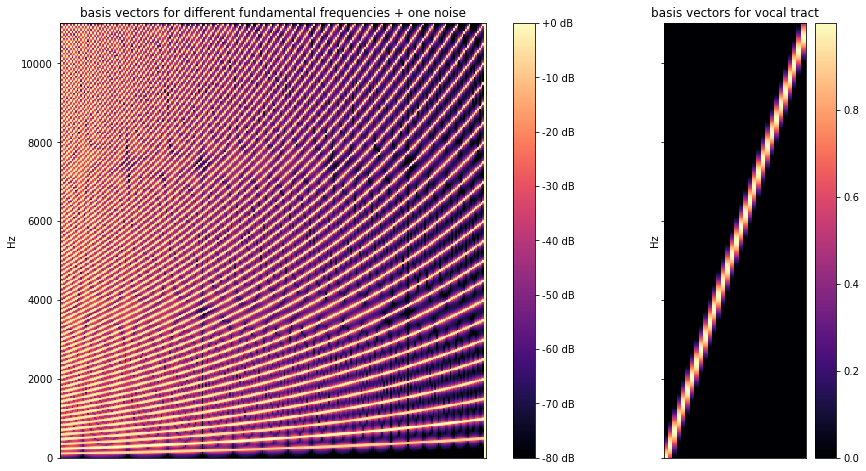

In [7]:
W_f0, freqs = get_harmonics()
W_filt = get_filters()

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(14, 8), gridspec_kw={'width_ratios': [3, 1]})
img1 = display.specshow(librosa.amplitude_to_db(W_f0, ref=np.max), y_axis='linear', sr=sr, ax=ax[0])
fig.colorbar(img1, ax=[ax[0]], format='%+2.0f dB')
ax[0].set(title="basis vectors for different fundamental frequencies + one noise")
img2 = display.specshow(W_filt, y_axis='linear', sr=sr, ax=ax[1])
fig.colorbar(img2, ax=[ax[1]])
ax[1].set(title="basis vectors for vocal tract")


plt.show()

## Define Source-Filter Vocal Model

SourceFilter(
  (source): NMF(249, out_channels=513)
  (filter): NMF(32, out_channels=513)
)


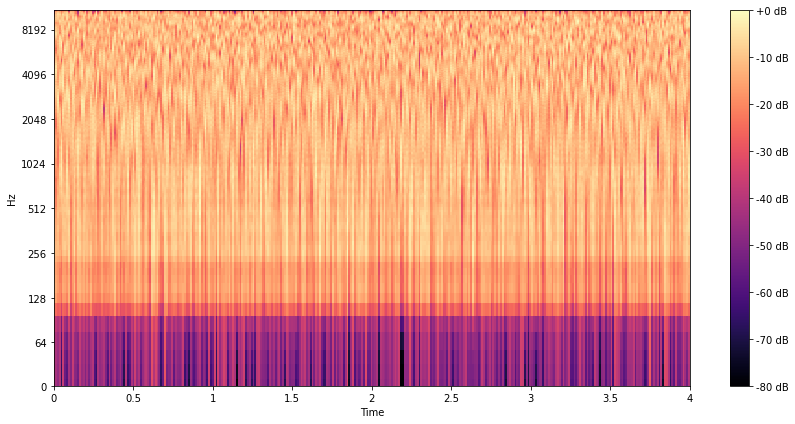

In [8]:
class SourceFilter(nn.Module):
    def __init__(self, Sshape, W_f0, W_filt):
        super().__init__()

        self.source = NMF(W=torch.tensor(W_f0), H=(S.shape[0], W_f0.shape[1]), trainable_W=False)
        self.filter = NMF(W=torch.Tensor(W_filt), H=(S.shape[0], W_filt.shape[1]), trainable_W=False)

    def forward(self):
        return self.source() * self.filter()


net = SourceFilter(S.shape, W_f0, W_filt)
print(net)

pred = net().detach()

fig = plt.figure(figsize=(12, 6))
display.specshow(librosa.amplitude_to_db(pred.numpy().T, ref=np.max), y_axis='log', x_axis='time', sr=sr, hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

## Training

In [9]:
net.train()
net = net#.cuda()
Scu = S#.cuda()

maxiter = 50
optim = BetaMu(net.parameters(), beta=1)
with tqdm(total=maxiter) as pbar:
    for i in range(maxiter):
        def closure():
            return Scu, net()
        net.zero_grad()
        optim.step(closure)
        loss = beta_div(net(), Scu, 1).item()
        pbar.set_postfix(loss=loss)
        pbar.update(1)

100%|██████████| 50/50 [00:00<00:00, 67.76it/s, loss=6.37e+3]


## View Learned Harmonics and Formants

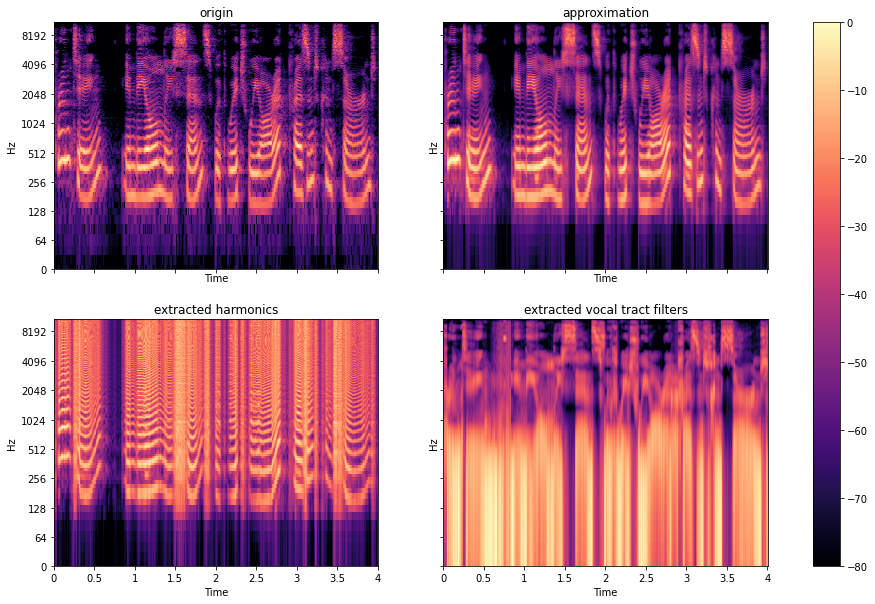

In [10]:
harms = net.source().detach().cpu().numpy().T
f0 = net.source.H.detach().cpu().numpy().T
filters = net.filter().detach().cpu().numpy().T
formants = net.filter.H.detach().cpu().numpy().T
approx = harms * filters

fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(16, 10))
img1 = display.specshow(librosa.amplitude_to_db(S.numpy().T, ref=np.max), y_axis='log', x_axis='time', 
                        sr=sr, hop_length=hop_length, ax=ax[0, 0])
ax[0, 0].set(title="origin")
display.specshow(librosa.amplitude_to_db(approx, ref=np.max), y_axis='log', x_axis='time', 
                 sr=sr, hop_length=hop_length, ax=ax[0, 1])
ax[0, 1].set(title="approximation")
display.specshow(librosa.amplitude_to_db(harms, ref=np.max), y_axis='log', x_axis='time', 
                 sr=sr, hop_length=hop_length, ax=ax[1, 0])
ax[1, 0].set(title="extracted harmonics")
display.specshow(librosa.amplitude_to_db(filters, ref=np.max), y_axis='log', x_axis='time', 
                 sr=sr, hop_length=hop_length, ax=ax[1, 1])
ax[1, 1].set(title="extracted vocal tract filters")
fig.colorbar(img1, ax=[ax[0, 0], ax[1, 0], ax[0, 1], ax[1, 1]])
plt.show()

## View Fundamental Frequencies and Formants

/home/ycy/miniconda3/envs/torch170/lib/python3.7/site-packages/librosa/display.py:848: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  out = axes.pcolormesh(x_coords, y_coords, data, **kwargs)


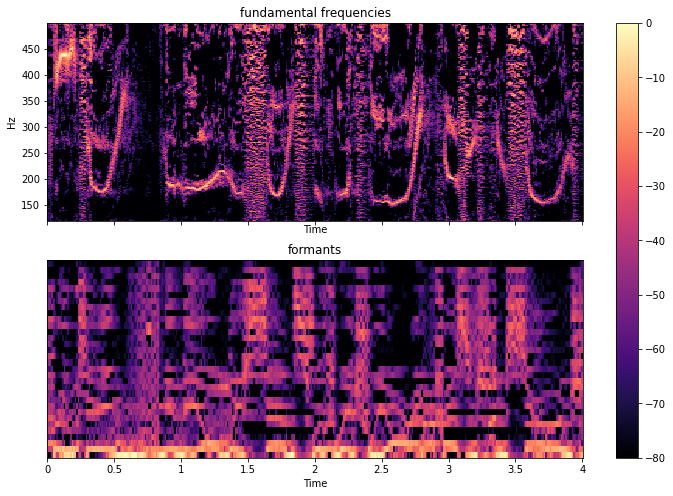

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 8))
img1 = display.specshow(librosa.amplitude_to_db(f0[:-1], ref=np.max), y_axis='linear', x_axis='time', y_coords=freqs,
                        sr=sr, hop_length=hop_length, ax=ax[0])
ax[0].set(title="fundamental frequencies")
display.specshow(librosa.amplitude_to_db(formants, ref=np.max), x_axis='time', 
                 sr=sr, hop_length=hop_length, ax=ax[1])
ax[1].set(title="formants")
fig.colorbar(img1, ax=ax)
plt.show()

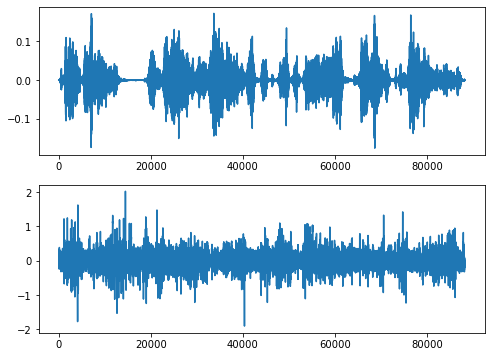

In [12]:
f0_S = torch.tensor(harms) * torch.exp(1j * torch.angle(Sraw))
# f0_t = torch.istft(f0_S, nfft, hop_length=hop_length, window=window)
f0_t = griffinlim(torch.tensor(harms), window, nfft, hop_length, nfft, 1, 32, 0., y.numel(), True)
tract_t = griffinlim(torch.tensor(filters), window, nfft, hop_length, nfft, 1, 32, 0., y.numel(), True)
approx_t = griffinlim(torch.tensor(approx), window, nfft, hop_length, nfft, 1, 32, 0., y.numel(), True)

fig = plt.figure(figsize=(8, 6))
plt.subplot(211)
plt.plot(f0_t)
plt.subplot(212)
plt.plot(tract_t)
plt.show()

In [13]:
ipd.Audio(f0_t.numpy(), rate=sr)

In [14]:
ipd.Audio(tract_t.numpy(), rate=sr)

In [15]:
ipd.Audio(approx_t.numpy(), rate=sr)